# Final model evaluation

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load dataset
data = pd.read_csv("fraud.csv")

X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P'].astype(int)

# Split 
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 9252, Val: 3084, Test: 3084


In [7]:
# Pipeline with SMOTEENN
lgb_clf = lgb.LGBMClassifier(random_state=42, n_estimators=500, verbose=-1)

baseline_model = Pipeline([
    ('smoteenn', SMOTEENN(random_state=42)),
    ('lgb', lgb_clf)
])


Number of selected features: 21
Number of dropped features: 23
Selected features: ['PolicyNumber', 'Age', 'RepNumber', 'Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'AgeVehicleRatio', 'Make_label_encoded', 'WeekOfMonth', 'DriverRating', 'Make_frequency_encoded', 'NumberOfSuppliments', 'WeekOfMonthClaimed', 'VehiclePrice', 'PastNumberOfClaims', 'BasePolicy', 'AgeOfVehicle', 'AddressChange_Claim', 'Fault', 'Deductible']
Dropped features: ['AccidentArea', 'Sex', 'MaritalStatus', 'VehicleCategory', 'Days_Policy_Accident', 'Days_Policy_Claim', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfCars', 'Year', 'DaysToClaimRatio', 'IsYoungDriver', 'IsOldVehicle', 'QuickClaim', 'NoPoliceReport', 'NoWitness', 'IsNewPolicy', 'HighDeductible', 'IsFrequentClaimant', 'AddressChanged', 'RiskScore']


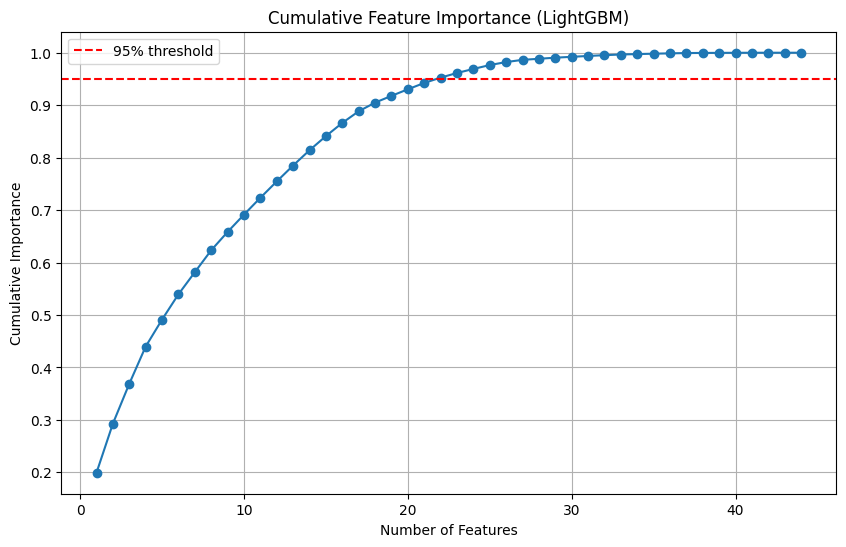

In [9]:
# Feature selection
lgb_clf_fs = lgb.LGBMClassifier(random_state=42, n_estimators=500, verbose=-1)
lgb_clf_fs.fit(X_train, y_train)

importances = pd.Series(lgb_clf_fs.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)
cumulative_importance = importances_sorted.cumsum() / importances_sorted.sum()

selected_features = cumulative_importance[cumulative_importance <= 0.95].index.tolist()
dropped_features = [f for f in X_train.columns if f not in selected_features]

print(f"Number of selected features: {len(selected_features)}")
print(f"Number of dropped features: {len(dropped_features)}")
print("Selected features:", selected_features)
print("Dropped features:", dropped_features)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance.values, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title("Cumulative Feature Importance (LightGBM)")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.legend()
plt.grid(True)
plt.show()

Below, we train the final baseline LightGBM model using the selected features. The training and validation sets are combined to form the full training data, allowing the model to learn from all available labeled samples before final evaluation.
The model is then evaluated on the untouched test set to obtain unbiased performance metrics.

In [11]:
X_full_train = pd.concat([X_train[selected_features], X_val[selected_features]])
y_full_train = pd.concat([y_train, y_val])

print("Full training data shape:", X_full_train.shape)
print("Test data shape:", X_test[selected_features].shape)

# Refit baseline model on full training data
baseline_model.fit(X_full_train, y_full_train)

# Evaluate on test set
X_test_selected = X_test[selected_features]
y_test_pred = baseline_model.predict(X_test_selected)
y_test_prob = baseline_model.predict_proba(X_test_selected)[:, 1]

# --- Evaluation metrics ---
print("\nFinal Test Set Evaluation")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Full training data shape: (12336, 21)
Test data shape: (3084, 21)

Final Test Set Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2899
           1       0.60      0.67      0.63       185

    accuracy                           0.95      3084
   macro avg       0.79      0.82      0.80      3084
weighted avg       0.96      0.95      0.95      3084

ROC-AUC: 0.9690256658866525
Confusion Matrix:
 [[2816   83]
 [  61  124]]


The final baseline LightGBM model performs strongly on the test set, achieving a high ROC-AUC of 0.97.  
It correctly identifies most fraud cases (recall = 0.67) while maintaining good precision (0.60), indicating a balanced trade-off between detecting fraud and limiting false alarms. These results suggest the model generalizes well and is effective for practical fraud detection use.

# Model Explainability (Using SHAP)

In [19]:
import shap
shap.initjs()

In [14]:
# Extract trained LightGBM model from pipeline
lgb_model = baseline_model.named_steps['lgb']

# Create SHAP explainer using training data
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_selected)


C:\Users\awcl2\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## Barplot and Beeswarm plot

Here, we find out which features are most influential in our prediction (Barplot), and how each feature influences fraud prediction (Beeswarm plot).

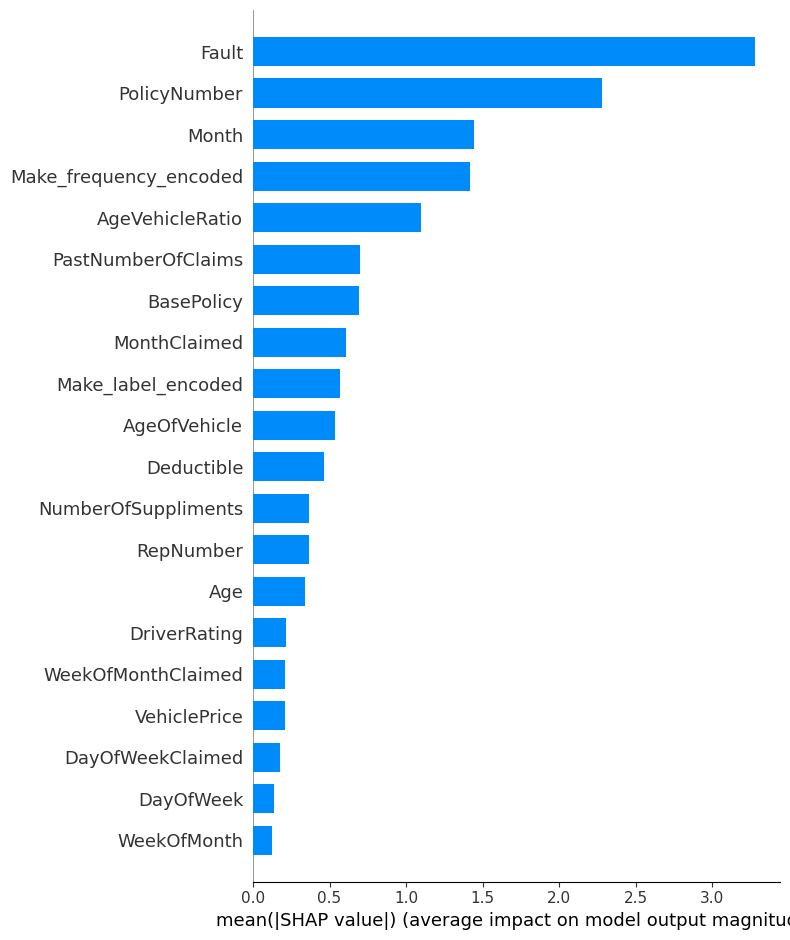

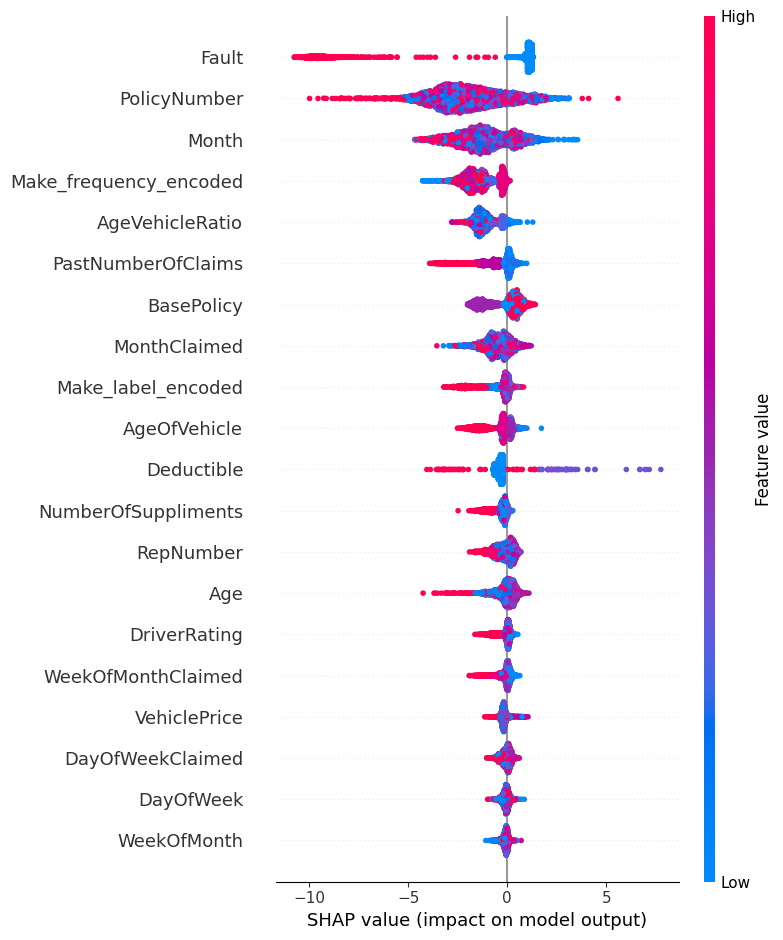

In [16]:
# Summary plot (feature impact across all test samples)
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

# Detailed summary with distribution of SHAP values
shap.summary_plot(shap_values, X_test_selected)


From the bar plot, the top 6 features influencing predictions are "Fault", "PolicyNumber", "Month","Make_frequency_encoded","AgeVehicleRatio", "PastNumberOfClaims". From the Beeswarm plot, we observe that for most of these 6 features, higher values tend to result in negative SHAP values, meaning non-fraud cases. Furthermore, although "Deductible" is not one of the top influencing features, we observe that lower "Deductible" tend to result in positive SHAP values (fraud cases), while high "Deductible" values tend to result in negative SHAP values (non-fraud cases)

## SHAP force plot

In [46]:
i = 2000  # example index
shap.force_plot(
    explainer.expected_value, 
    shap_values[i, :], 
    X_test_selected.iloc[i]
)

This SHAP force plot illustrates how the model makes a prediction for a single policy case (index 2000).
The base value (~2.6) represents the model’s average predicted log-odds of fraud across all samples.
Each feature then pushes this prediction higher (red arrows) or lower (blue arrows) depending on its value. 
In this example, features such as WeekOfMonth = 4, PolicyNumber = 3885, Month = 5, and Fault = 0
push the prediction slightly higher toward fraud, while factors like Make_label_encoded = 17,
AgeVehicleRatio = 6.44, and AgeOfVehicle = 8 pull the prediction lower toward non-fraud.
The final model output (f(x) = 1.18) reflects the combined influence of all these factors.
This demonstrates how the LightGBM model uses feature-level contributions to arrive at an
individual prediction, providing transparency into why a specific case was classified as more
or less likely to be fraudulent.

## Partial Dependence Plots (PDP)

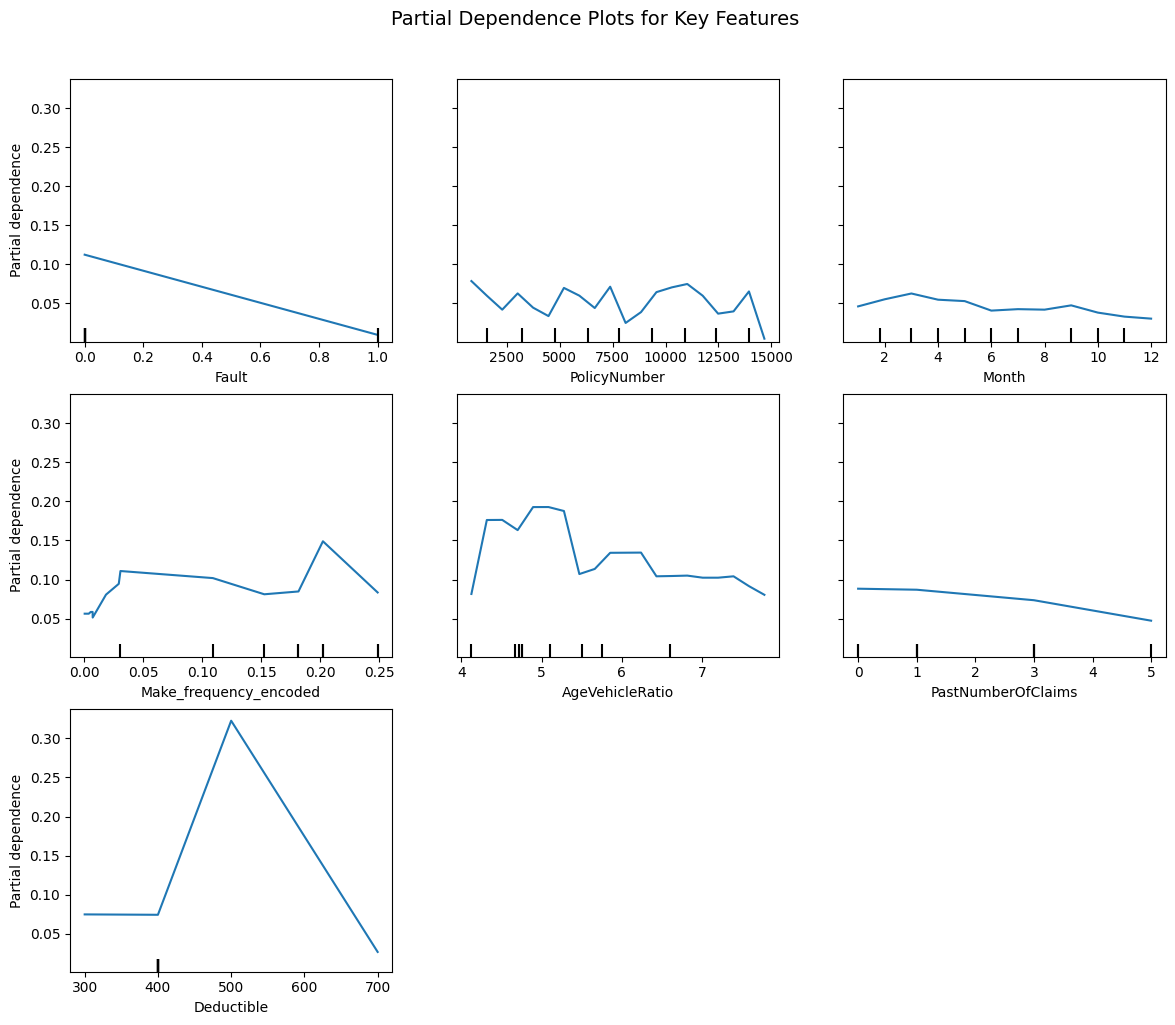

In [48]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10)) 

PartialDependenceDisplay.from_estimator(
    lgb_model,
    X_test_selected,
    features=[
        'Fault', 'PolicyNumber', 'Month', 'Make_frequency_encoded',
        'AgeVehicleRatio', 'PastNumberOfClaims', 'Deductible'
    ],
    grid_resolution=20,
    ax=ax
)

plt.suptitle("Partial Dependence Plots for Key Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()



Each curve from the PDPs shows the average predicted fraud probability as the feature varies across its range, helping us to highlight the marginal effect of individual features on predictions. For instance, as the "Fault" feature value increases, we observe decreasing probability of fraud. Another example would be when "Deductible" values are lower (400 to 500), there is increasing probability of fraud. When "Deductible" values are higher (500 to 700), probability of fraud decreases. The observations from the PDPs are consistent with our observations from the Beeswarm plot earlier.